# Задача

- [✔️] Самостоятельно реализовать функцию gradient_descent(X, y), которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал методом градиентного спуска (Batch Gradient Descent, GD) и возвращая вектор весов w. В качестве функционала можно выбрать, например, функцию ошибок *MSE* + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [✔️] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин тут (целевой признак для предсказания --- price).
- [✔️] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
- [✔️] Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- [✔] Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.
- [✔] При обучении моделей использовать масштабирование данных.
- [✔] Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y). Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и $R^2$.
- [✔] Обучить модель, используя существующую библиотеку. Например, в sklearn для $L_2$-регуляризатора можно использовать Ridge. Сравнить качество с Вашей реализацией.
- [✔] Повторить тоже самое, но используя кросс-валидацию.
- [✔] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.
- [✔] \* (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE) из sklearn.
- [✔] \* (+1 балл) Во все ваши реализации добавить возможность настройки нужных гиперпараметров, а в процессе обучения всех моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [✔] \* (+1 балл) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.
- [✔] \* (+1 балл) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.

In [880]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import random
from sklearn.model_selection import KFold

random.seed(19)
np.random.seed(19)

Реализуем `gradient_descent(X, y)`, использующий Batch Gradient Descent и MSE + $L_2$-регуляризатор в качестве фукнционала.

In [881]:

def add_dummy_feature(X: np.ndarray):
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    ones = np.ones((X.shape[0], 1))
    return np.hstack((ones, X))

def gradient_descent(X: np.ndarray, y: np.ndarray, alpha=1, lr=1E-1, epsilon=1E-4, num_iterations=20000):
    X = add_dummy_feature(X)

    num_samples, num_features = X.shape
    weights = np.random.randn(num_features, )

    iteration = 0

    for _ in range(num_iterations):
        predictions = np.dot(X, weights)
        errors = predictions - y

        gradients = (2 / num_samples) * np.dot(X.T, errors) + alpha * np.hstack(([0], weights[1:]))

        weights -= lr * gradients

        if iteration > 0 and np.all(abs(lr * gradients) < epsilon):
            break

        iteration += 1

    return weights


In [882]:
def linear_predict(X: np.ndarray, weights: np.ndarray):
    X = add_dummy_feature(X)
    return np.dot(X, weights)

Реализуем стохастический градиентный спуск

In [883]:
def stochastic_gradient_descent(X, y, alpha=1E-1, lr=1E-2, tolerance=1E-4, max_iterations=100_000):
    X_with_bias = np.hstack((np.ones((X.shape[0], 1)), X))
    
    weights = np.ones(X_with_bias.shape[1])

    prev_cost = float('inf')

    for iteration in range(max_iterations):
        sample_index = random.sample(range(X.shape[0]), 1)
        X_sample = X_with_bias[sample_index]
        y_sample = y[sample_index]

        prediction = np.dot(X_sample, weights)
        error = y_sample - prediction

        gradient = -2 * np.dot(X_sample.T, error)
        gradient_regularization = 2 * alpha * weights
        gradient_regularization[0] = 0
        total_gradient = gradient + gradient_regularization

        weights -= lr * total_gradient

        current_cost = np.mean(error ** 2) + alpha * np.sum(weights ** 2)
        if abs(prev_cost - current_cost) < tolerance:
            return weights

        prev_cost = current_cost

    return weights

Реализуем метод мини-пакетного градиентного спуска

In [884]:
def mini_batch_gradient_descent(X, y, num_batches=10, alpha=0.1, lr=1E-2, tolerance=1E-4, max_epochs=100_000):
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    
    weights = np.ones(X.shape[1])

    prev_cost = float('inf')

    for epoch in range(max_epochs):
        batch_indices = random.sample(range(X.shape[0]), num_batches)

        for batch_idx in batch_indices:
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]

            predictions = np.dot(X_batch, weights)
            errors = y_batch - predictions

            gradient = -2 * np.dot(errors, X_batch) / num_batches
            gradient += 2 * alpha * weights
            
            gradient[0] -= 2 * alpha * weights[0]

            weights -= lr * gradient

            cost = np.mean(errors ** 2) + alpha * np.sum(weights ** 2)
            if abs(prev_cost - cost) < tolerance:
                return weights

            prev_cost = cost

    return weights

Используем данные с характеристиками машин и их ценой, целевой признак: `price`.
Признаки:
- car_ID: номер строки в датасете
- symboling: уровень риска авто (чем ниже, тем безопаснее)
- CarName: наименование
- fueltype: тип топлива
- aspiration: тип наддува
- doornumber: количество дверей
- carbody: тип кузова
- drivewheel: тип привода
- enginelocation: расположение двигателя
- wheelbase: колёсная база автомобиля
- carlenght: длина автомобиля
- carwidth: ширина автомобиля
- curbweight: вес автомобиля
- enginetype: тип двигателя автомобиля
- cylindernumber: количество цилиндров в двигателе
- enginesize: размер двигателя
- fuelsystem: тип топливной системы
- boreratio: соотношение диаметра цилиндра и хода
- stroke: расстояние, проходимое поршнем за каждый цикл
- compessionratio: соотношение объема цилиндра с поршнем в нижнем и в верхнем положении
- horsepower: количество лошадиных сил
- peakrpm: максимальное количество оборотов в минуту
- citympg: расход топлива в городе
- highwaympg: расход топлива на трассе
- price: цена автомобиля

Данные взяты отсюда: https://www.kaggle.com/code/dronax/car-prices-dataset

Считываем данные. Выполним первичный анализ данных, при необходимости проведём чистку данных (Data Cleaning).

In [885]:
path = "../data/car_price/car_price.csv"
df = pd.read_csv(path)

print(df.head())

   car_ID  symboling                   CarName fueltype aspiration doornumber      carbody  ... stroke compressionratio  horsepower  peakrpm  \
0       1          3        alfa-romero giulia      gas        std        two  convertible  ...   2.68              9.0         111     5000   
1       2          3       alfa-romero stelvio      gas        std        two  convertible  ...   2.68              9.0         111     5000   
2       3          1  alfa-romero Quadrifoglio      gas        std        two    hatchback  ...   3.47              9.0         154     5000   
3       4          2               audi 100 ls      gas        std       four        sedan  ...   3.40             10.0         102     5500   
4       5          2                audi 100ls      gas        std       four        sedan  ...   3.40              8.0         115     5500   

   citympg  highwaympg    price  
0       21          27  13495.0  
1       21          27  16500.0  
2       19          26  16500.0  

Начальная чистка данных

In [886]:
# Пустых значений нет
print(df.isna().sum())

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64


In [887]:
# Колонка с индексом не нужна
df.drop(columns=["car_ID"], inplace=True)

In [888]:
df['CarName'].unique()

array(['alfa-romero giulia', 'alfa-romero stelvio',
       'alfa-romero Quadrifoglio', 'audi 100 ls', 'audi 100ls',
       'audi fox', 'audi 5000', 'audi 4000', 'audi 5000s (diesel)',
       'bmw 320i', 'bmw x1', 'bmw x3', 'bmw z4', 'bmw x4', 'bmw x5',
       'chevrolet impala', 'chevrolet monte carlo', 'chevrolet vega 2300',
       'dodge rampage', 'dodge challenger se', 'dodge d200',
       'dodge monaco (sw)', 'dodge colt hardtop', 'dodge colt (sw)',
       'dodge coronet custom', 'dodge dart custom',
       'dodge coronet custom (sw)', 'honda civic', 'honda civic cvcc',
       'honda accord cvcc', 'honda accord lx', 'honda civic 1500 gl',
       'honda accord', 'honda civic 1300', 'honda prelude',
       'honda civic (auto)', 'isuzu MU-X', 'isuzu D-Max ',
       'isuzu D-Max V-Cross', 'jaguar xj', 'jaguar xf', 'jaguar xk',
       'maxda rx3', 'maxda glc deluxe', 'mazda rx2 coupe', 'mazda rx-4',
       'mazda glc deluxe', 'mazda 626', 'mazda glc', 'mazda rx-7 gs',
       'mazda glc 

In [889]:
# Исправим опечатки в названиях марок
df['brand'] = df['CarName'].str.split(' ').str[0]
print(df['CarName'].str.split(' ').str[0].unique())

df['brand'] = df['brand'].replace({'porcshce': 'porsche', 'toyouta': 'toyota',
                                   'maxda': 'mazda', 'nissan': 'Nissan', 
                                   'vw': 'volkswagen', 'vokswagen': 'volkswagen'})

df['Model'] = df['CarName'].str.split(' ').str[1:].apply(' '.join)
df.drop(columns=['CarName'], inplace=True)

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']


In [890]:
# Сконвертируем категориальные признаки в числовые, где возможно
df['doornumber'] = df['doornumber'].map({'four': 4, 'two': 2})
df['cylindernumber'] = df['cylindernumber'].map({'twelve': 12, 'eight': 8, 'six': 6, 'five': 5,
                                                 'four': 4, 'three': 3, 'two': 2})
print(df.head())

   symboling fueltype aspiration  doornumber      carbody drivewheel enginelocation  ...  horsepower  peakrpm  citympg  highwaympg    price  \
0          3      gas        std           2  convertible        rwd          front  ...         111     5000       21          27  13495.0   
1          3      gas        std           2  convertible        rwd          front  ...         111     5000       21          27  16500.0   
2          1      gas        std           2    hatchback        rwd          front  ...         154     5000       19          26  16500.0   
3          2      gas        std           4        sedan        fwd          front  ...         102     5500       24          30  13950.0   
4          2      gas        std           4        sedan        4wd          front  ...         115     5500       18          22  17450.0   

         brand         Model  
0  alfa-romero        giulia  
1  alfa-romero       stelvio  
2  alfa-romero  Quadrifoglio  
3         audi   

EDA

In [891]:
unique_values = df[['brand', 'Model']].drop_duplicates()
print(unique_values)

# всего 203 различных модели при том, что в таблице всего 205 строчек.
# Модель не получится использовать для обучения, поэтому удалим её
df.drop(columns=['Model'], inplace=True)

           brand         Model
0    alfa-romero        giulia
1    alfa-romero       stelvio
2    alfa-romero  Quadrifoglio
3           audi        100 ls
4           audi         100ls
..           ...           ...
196        volvo         244dl
197        volvo           245
198        volvo         264gl
199        volvo        diesel
203        volvo           246

[142 rows x 2 columns]


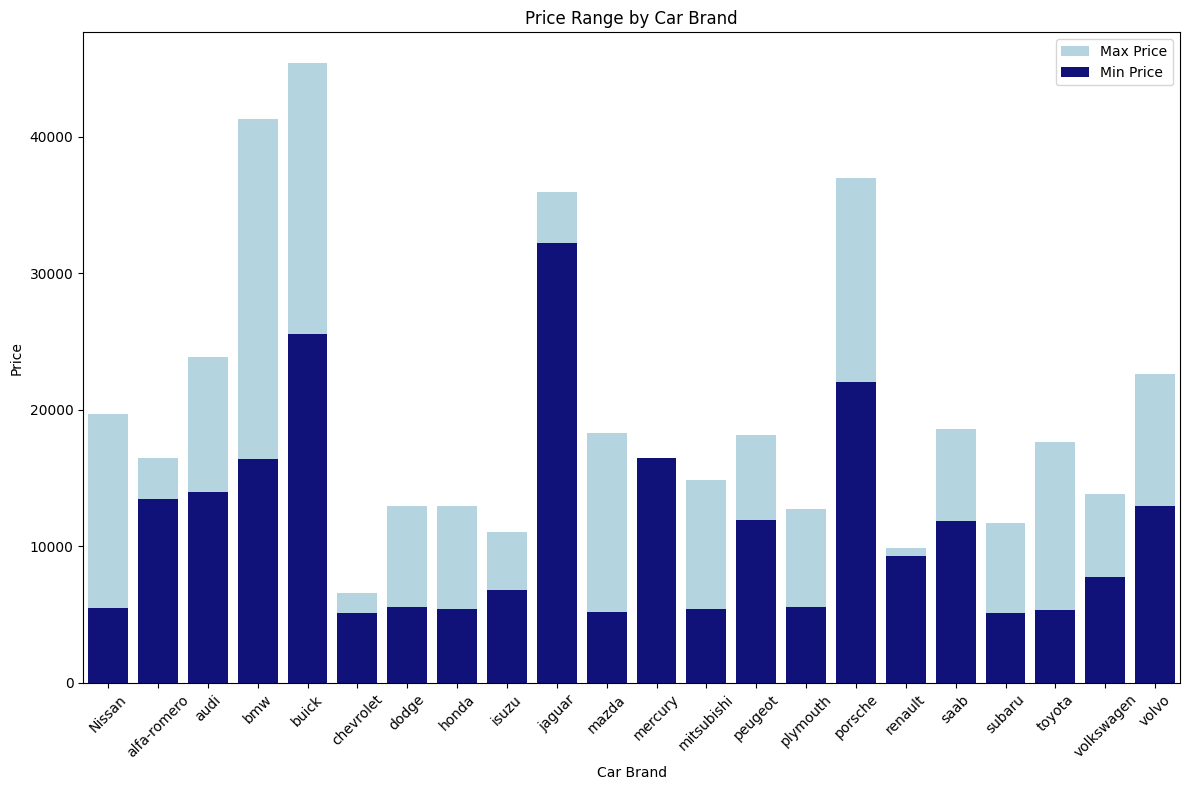

In [892]:
# Построение графика средней цены автомобиля по маркам
price_ranges = df.groupby('brand')['price'].agg(['min', 'max']).reset_index()

plt.figure(figsize=(12, 8))

sns.barplot(data=price_ranges, x='brand', y='max', color='lightblue', label='Max Price')
sns.barplot(data=price_ranges, x='brand', y='min', color='darkblue', label='Min Price')

plt.xticks(rotation=45)
plt.ylabel('Price')
plt.xlabel('Car Brand')
plt.title('Price Range by Car Brand')
plt.legend()
plt.tight_layout()

plt.show()

Можно видеть, что внутри одной марки разброс цен может быть существенным для разных моделей, то есть характеристики автомобиля влияют гораздо больше, чем марка. При этом марка является категориальным значением, которое не преобразовать в числовое, удалим эту колонку.

In [893]:
df.drop(columns=['brand'], inplace=True)

In [894]:
print(df.describe())

        symboling  doornumber   wheelbase   carlength    carwidth   carheight   curbweight  ...      stroke  compressionratio  horsepower  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   205.000000  ...  205.000000        205.000000  205.000000   
mean     0.834146    3.121951   98.756585  174.049268   65.907805   53.724878  2555.565854  ...    3.255415         10.142537  104.117073   
std      1.245307    0.994966    6.021776   12.337289    2.145204    2.443522   520.680204  ...    0.313597          3.972040   39.544167   
min     -2.000000    2.000000   86.600000  141.100000   60.300000   47.800000  1488.000000  ...    2.070000          7.000000   48.000000   
25%      0.000000    2.000000   94.500000  166.300000   64.100000   52.000000  2145.000000  ...    3.110000          8.600000   70.000000   
50%      1.000000    4.000000   97.000000  173.200000   65.500000   54.100000  2414.000000  ...    3.290000          9.000000   95.000000   
75%      2.00

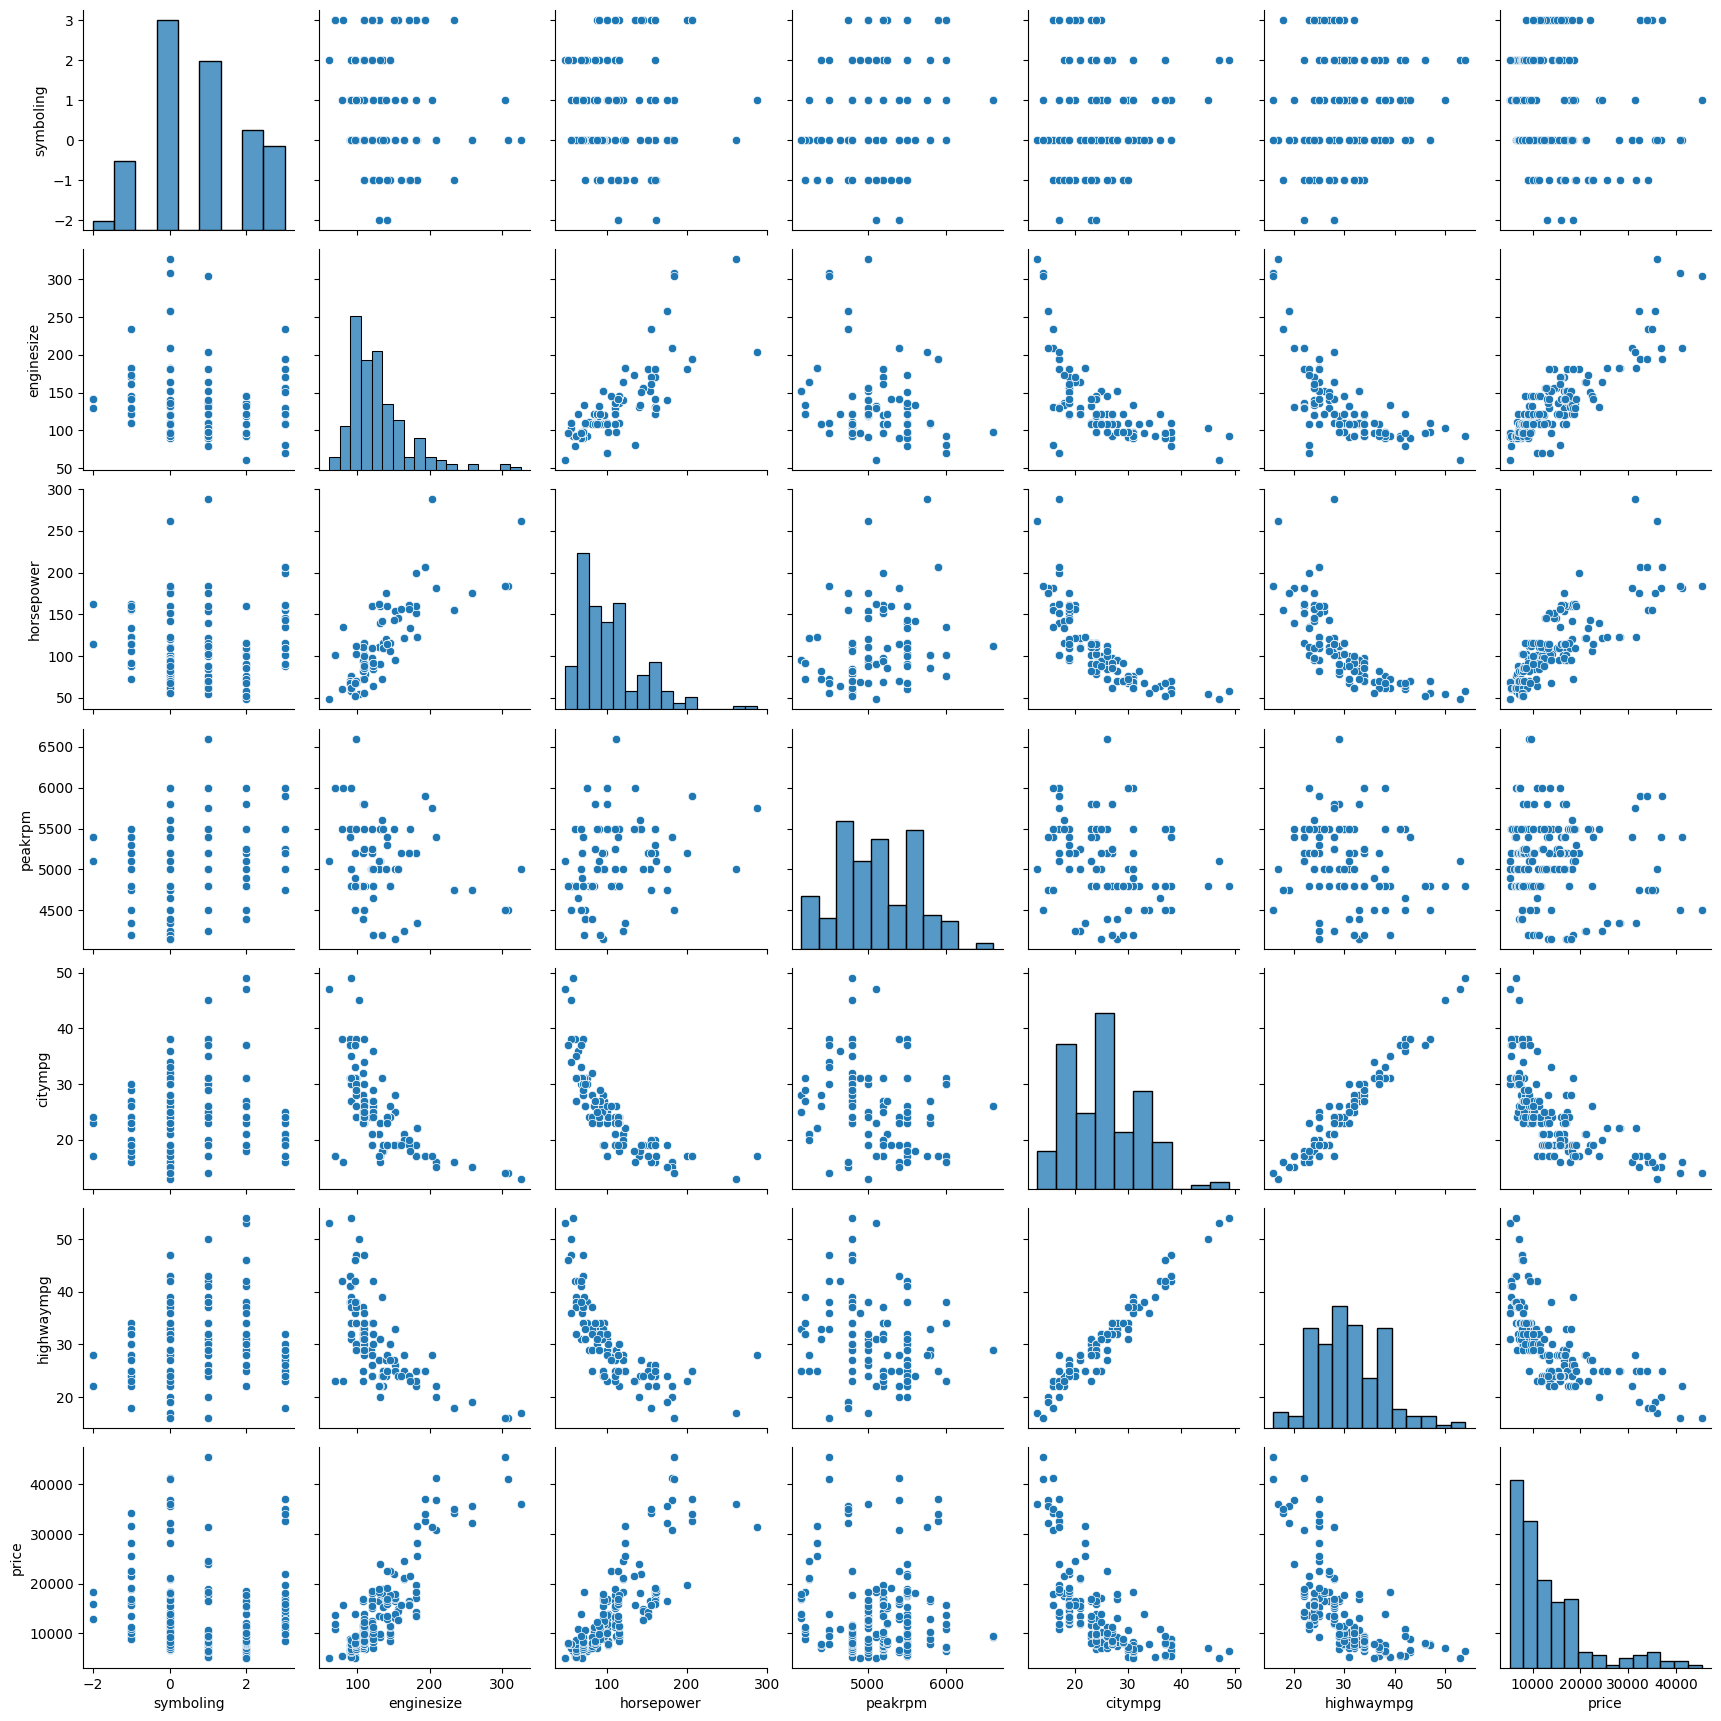

In [895]:
# Построение диаграмм рассеивания для быстрого анализа отношений и распределений
selected_columns = ['symboling', 'enginesize', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']
sns.pairplot(df[selected_columns])
plt.show()

Уже отсюда можно видеть, что symboling никак не связан с ценой. И при этом он является категориальным признаком, удалим его.

In [896]:
df.drop(columns=['symboling'], inplace=True)

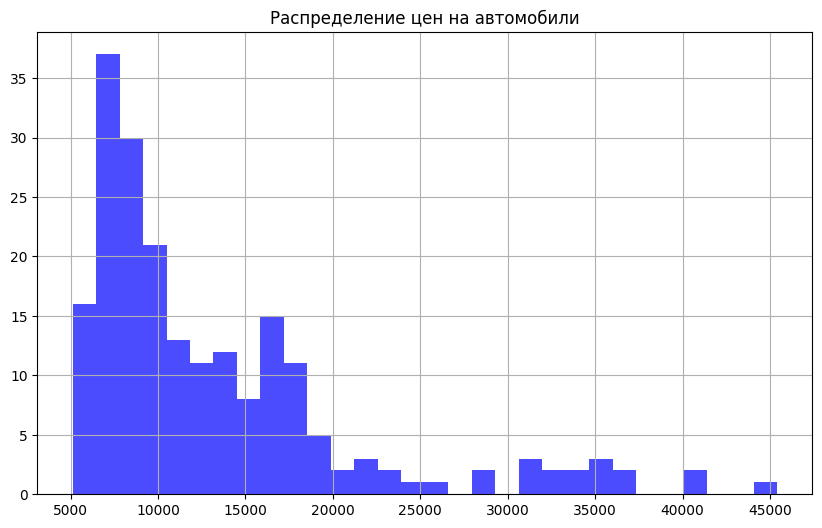

In [897]:
df['price'].hist(bins=30, color='blue', alpha=0.7, figsize=(10, 6))
plt.title("Распределение цен на автомобили")
plt.show()

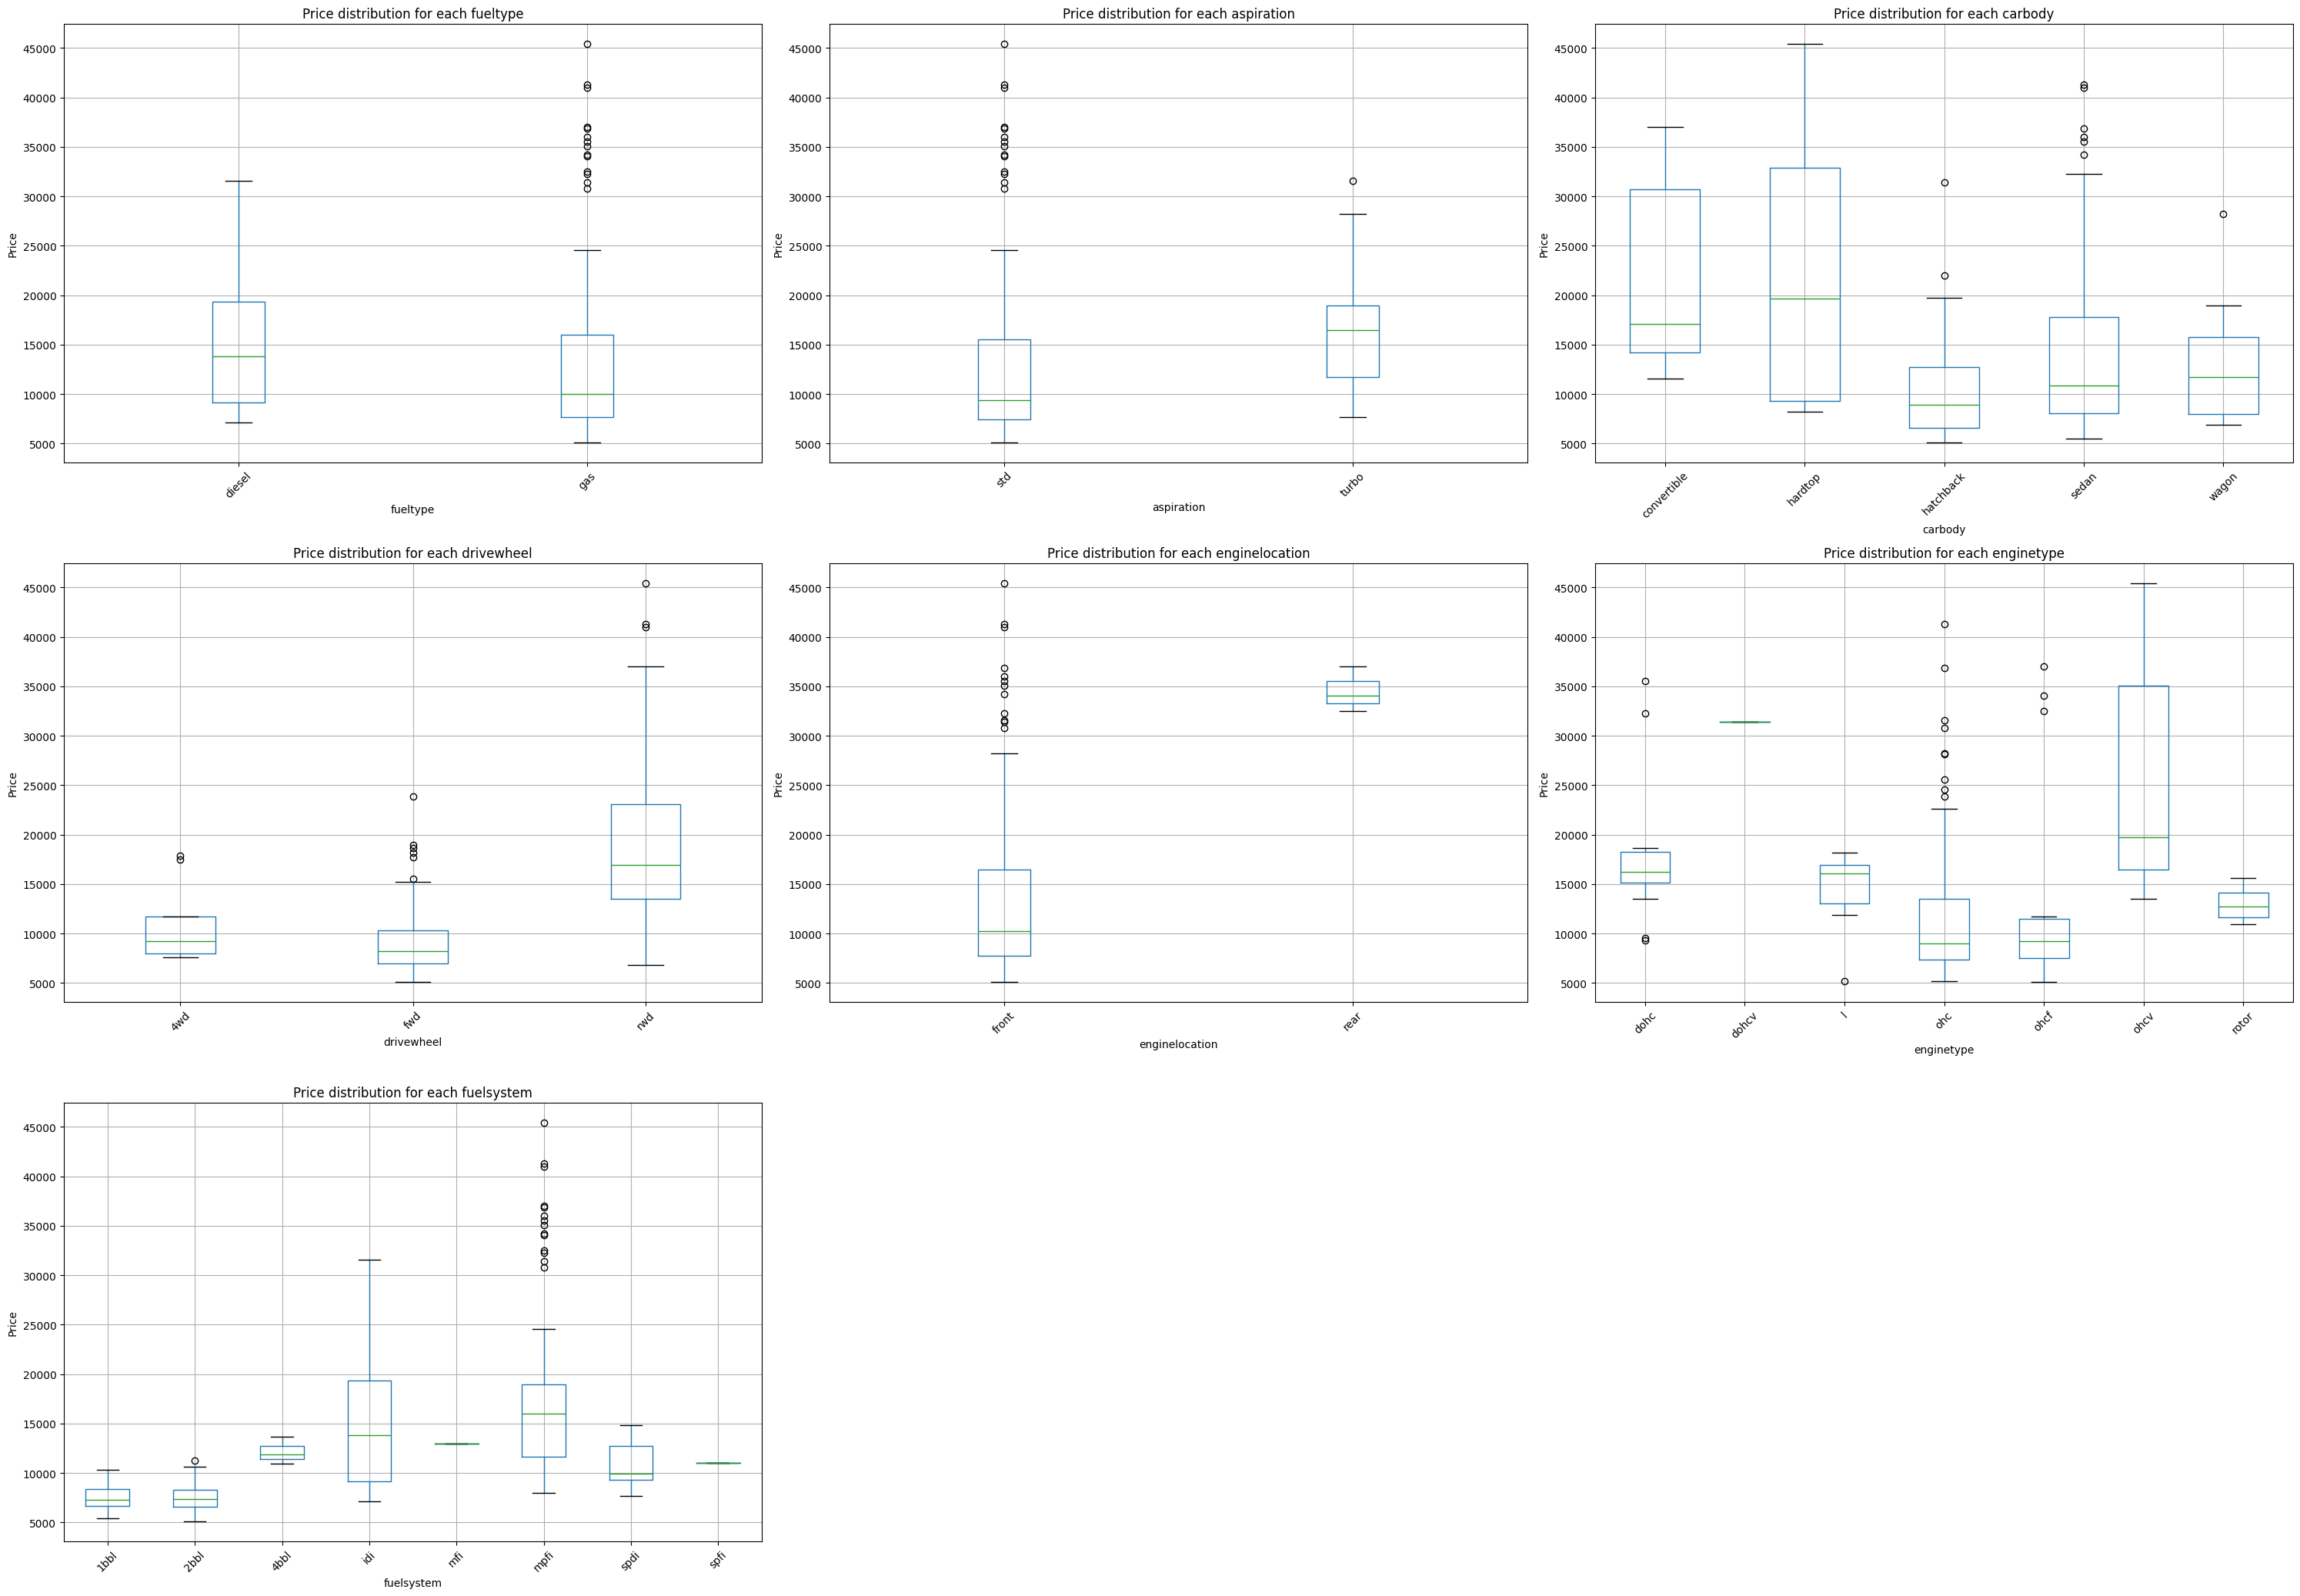

In [898]:
non_numeric_columns = df.select_dtypes(include=['object', 'category']).columns

non_numeric_columns = [col for col in non_numeric_columns]

filtered_columns = [col for col in non_numeric_columns if len(df[col].unique()) <= 30]  # adjust as necessary

num_plots = len(filtered_columns)

num_rows = num_plots // 3 + (num_plots % 3 > 0)
num_cols = min(num_plots, 3) 

plt.figure(figsize=(10 * num_cols, 7 * num_rows)) 

for i, column in enumerate(filtered_columns, 1):
    ax = plt.subplot(num_rows, num_cols, i) 

    df.boxplot(column='price', by=column, ax=ax)

    ax.set_title('Price distribution for each {}'.format(column))
    ax.set_xlabel(column)
    ax.set_ylabel('Price')
    plt.xticks(rotation=45) 
    plt.suptitle('') 

plt.tight_layout()
plt.show()

Видно, что между целевым признаком цены и `fueltype`, `aspiration` скорее всего нет зависимости или она слабая, поэтому удалим их сразу.

In [899]:
df.drop(columns=['fueltype', 'aspiration'], inplace=True)

Остальные категориальные признаки приобразуем в числовые по следующем принципу. Если медианная цена для значения выше медианной по всем значениям, то поставим 1, иначе 0.

In [900]:
global_median = df['price'].median()
non_numeric_columns = df.select_dtypes(include=['object', 'category']).columns

# Process each non-numeric column individually
for column in non_numeric_columns:
    # For each unique value in the column, determine if the median 'price' of that value is greater than the global median
    # Then assign 1 or 0 accordingly.
    
    # This creates a series where the index is the unique value and the value is the median price for that category
    median_per_value = df.groupby(column)['price'].median()
    
    # This transformation checks if the median price per category is greater than the global median
    transformed_values = (median_per_value > global_median).astype(int)

    # Now we map this transformation back to our original dataframe
    df[column] = df[column].map(transformed_values)


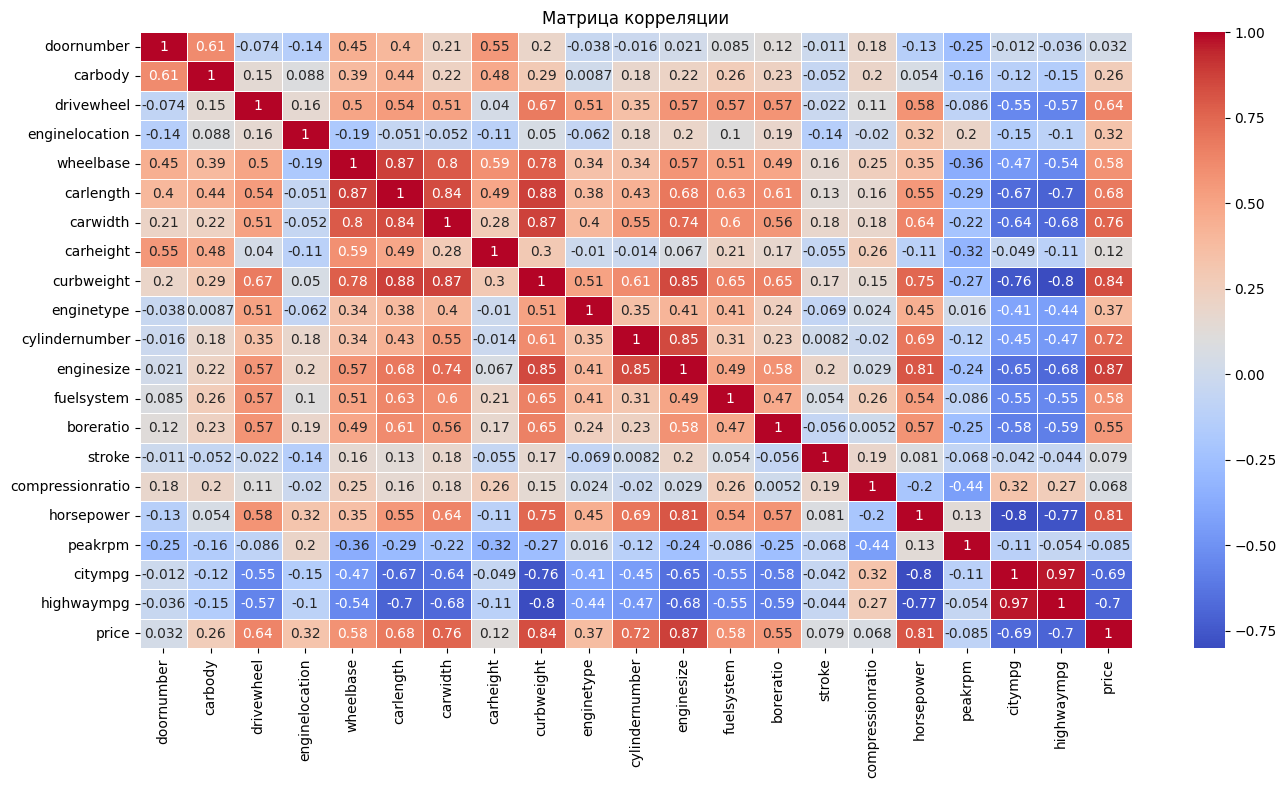

In [901]:
# Построим матрицу корреляции
corr_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

Между многими нецелевыми признаками есть сильная корреляция, какие-то из них можно было бы удалить сразу. Пока их оставим и воспользуемся позже Recursive Feature Elimination (RFE) из sklearn выявления важных признаков

Выполним масштабирование признаков

In [902]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,-1.130388,0.720082,1.302831,-0.121867,-1.690772,-0.426521,-0.844782,...,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059,0.027391
1,-1.130388,0.720082,1.302831,-0.121867,-1.690772,-0.426521,-0.844782,...,-1.839377,-0.288349,0.174483,-0.262960,-0.646553,-0.546059,0.404461
2,-1.130388,-1.388730,1.302831,-0.121867,-0.708596,-0.231513,-0.190566,...,0.685946,-0.288349,1.264536,-0.262960,-0.953012,-0.691627,0.404461
3,0.884652,0.720082,-0.767559,-0.121867,0.173698,0.207256,0.136542,...,0.462183,-0.035973,-0.053668,0.787855,-0.186865,-0.109354,0.084485
4,0.884652,0.720082,-0.767559,-0.121867,0.107110,0.207256,0.230001,...,0.462183,-0.540725,0.275883,0.787855,-1.106241,-1.273900,0.523668


Разобьем выборку на обучающую и тестовую

In [903]:
y = df['price']
X = df.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Выделим наилучшее подмножество признаков, используя RFE из sklearn

In [904]:
estimator = LinearRegression()

selector = RFECV(estimator, step=1, cv=5)

selector = selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.support_]

for column in selected_columns:
    print(column)

X = X[selected_columns]

carbody
drivewheel
enginelocation
wheelbase
carlength
carwidth
curbweight
enginetype
cylindernumber
enginesize
boreratio
stroke
compressionratio
horsepower
peakrpm
citympg
highwaympg


Подберём гиперпараметры

In [905]:
ridge = Ridge()

param_grid = {
    'alpha': np.logspace(0, 2, 10),
    'tol': np.logspace(-5, 1, 10)
}

grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_tol = grid_search.best_params_['tol']
print(f'alpha: {best_alpha}, tol: {best_tol}')

alpha: 12.91549665014884, tol: 1e-05


Обучим модели и сравним качество

In [906]:
models=[(gradient_descent, 'Gradient Descent'), 
        (stochastic_gradient_descent, 'Stochastic GD'), 
        (mini_batch_gradient_descent, 'Mini-batch GD')]

In [907]:
def evaluate_model(predictions, actual_values):
    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_values, predictions)
    return {'MSE': mse, 'RMSE': rmse, 'R^2': r2}

ridge_model = Ridge(alpha=best_alpha, tol=best_tol)
ridge_model.fit(X_train, y_train)

evaluation_results = {}

ridge_train_preds = ridge_model.predict(X_train)
ridge_test_preds = ridge_model.predict(X_test)
evaluation_results['Ridge'] = {
    'Train': evaluate_model(ridge_train_preds, y_train),
    'Test': evaluate_model(ridge_test_preds, y_test)
}

for model_func, name in models:
    
    weights = model_func(X_train.values, y_train.values)
    
    train_predictions = linear_predict(X_train.values, weights)
    test_predictions = linear_predict(X_test.values, weights)
    
    evaluation_results[name] = {
        'Train': evaluate_model(train_predictions, y_train),
        'Test': evaluate_model(test_predictions, y_test)
    }

results_df = pd.DataFrame(evaluation_results).T
organized_df = pd.concat({k: pd.DataFrame(v).T for k, v in results_df.to_dict().items()}, axis=0)
organized_df.index.names = ['Data', 'Model']

print(organized_df)

                             MSE      RMSE       R^2
Data  Model                                         
Train Ridge             0.099879  0.316037  0.893635
      Gradient Descent  0.122668  0.350240  0.869366
      Stochastic GD     0.121118  0.348020  0.871017
      Mini-batch GD     0.143072  0.378249  0.847637
Test  Ridge             0.226079  0.475478  0.818119
      Gradient Descent  0.260902  0.510786  0.790104
      Stochastic GD     0.288107  0.536756  0.768218
      Mini-batch GD     0.278622  0.527846  0.775849


Теперь обучим модели используя кросс-валидацию

In [908]:
num_splits = 5

kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

def cross_validate_model(model, X, y, model_func=None):
    fold_metrics = {
        'mse-train': [], 'mse-test': [],
        'rmse-train': [], 'rmse-test': [],
        'r2-train': [], 'r2-test': []
    }

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if model_func:
            weights = model_func(X_train.values, y_train.values)
            train_preds = linear_predict(X_train.values, weights)
            test_preds = linear_predict(X_test.values, weights)
        else:
            model.fit(X_train, y_train)
            train_preds = model.predict(X_train)
            test_preds = model.predict(X_test)

        train_metrics = evaluate_model(train_preds, y_train)
        test_metrics = evaluate_model(test_preds, y_test)

        fold_metrics['mse-train'].append(train_metrics['MSE'])
        fold_metrics['mse-test'].append(test_metrics['MSE'])
        fold_metrics['rmse-train'].append(train_metrics['RMSE'])
        fold_metrics['rmse-test'].append(test_metrics['RMSE'])
        fold_metrics['r2-train'].append(train_metrics['R^2'])
        fold_metrics['r2-test'].append(test_metrics['R^2'])

    summary_metrics = {}
    for metric, values in fold_metrics.items():
        summary_metrics[metric] = {'E': np.mean(values), 'STD': np.std(values)}

    return fold_metrics, summary_metrics

def print_model_results(model_name, metrics):
    metric_data = {}
    for metric_type, values in metrics.items():
        fold_data = {f'Fold{i+1}': value for i, value in enumerate(values)}
        fold_data['E'] = np.mean(values)
        fold_data['STD'] = np.std(values)
        metric_data[metric_type] = fold_data

    model_df = pd.DataFrame.from_dict(metric_data, orient='index')
    print(model_df)

all_results = {}

ridge_model = Ridge(alpha=best_alpha, tol=best_tol)
ridge_fold_metrics, ridge_summary_metrics = cross_validate_model(ridge_model, X, y)
all_results['Ridge'] = ridge_fold_metrics

for model_func, name in [(gradient_descent, 'Gradient Descent'), 
                         (stochastic_gradient_descent, 'Stochastic GD'), 
                         (mini_batch_gradient_descent, 'Mini-batch GD')]:
    custom_fold_metrics, custom_summary_metrics = cross_validate_model(None, X, y, model_func=model_func)
    all_results[name] = custom_fold_metrics

In [909]:
model_name = 'Ridge'
metrics = all_results[model_name]
print_model_results(model_name, metrics)

               Fold1     Fold2     Fold3     Fold4     Fold5         E       STD
mse-train   0.100321  0.121886  0.133972  0.122868  0.108717  0.117553  0.011761
mse-test    0.225486  0.107097  0.061512  0.128804  0.185328  0.141646  0.057823
rmse-train  0.316735  0.349122  0.366022  0.350525  0.329722  0.342425  0.017255
rmse-test   0.474854  0.327257  0.248015  0.358893  0.430498  0.367903  0.079326
r2-train    0.893165  0.888533  0.872012  0.874601  0.884051  0.882472  0.008061
r2-test     0.818596  0.818457  0.924301  0.880803  0.848209  0.858073  0.040319


In [910]:
model_name = 'Gradient Descent'
metrics = all_results[model_name]
print_model_results(model_name, metrics)

               Fold1     Fold2     Fold3     Fold4     Fold5         E       STD
mse-train   0.124059  0.156348  0.166071  0.147535  0.132833  0.145369  0.015265
mse-test    0.258746  0.103782  0.089805  0.150774  0.205090  0.161639  0.063156
rmse-train  0.352221  0.395408  0.407518  0.384103  0.364463  0.380742  0.020109
rmse-test   0.508670  0.322152  0.299674  0.388296  0.452869  0.394332  0.078366
r2-train    0.867885  0.857017  0.841347  0.849426  0.858330  0.854801  0.008927
r2-test     0.791839  0.824077  0.889483  0.860472  0.832024  0.839579  0.033176


In [911]:
model_name = 'Stochastic GD'
metrics = all_results[model_name]
print_model_results(model_name, metrics)

               Fold1     Fold2     Fold3     Fold4     Fold5         E       STD
mse-train   0.139428  0.204303  0.268839  0.205320  0.138419  0.191262  0.048713
mse-test    0.215542  0.139991  0.203680  0.231990  0.216164  0.201473  0.032031
rmse-train  0.373401  0.451999  0.518497  0.453123  0.372048  0.433813  0.055389
rmse-test   0.464265  0.374153  0.451309  0.481653  0.464934  0.447263  0.037803
r2-train    0.851518  0.813160  0.743169  0.790451  0.852372  0.810134  0.040933
r2-test     0.826596  0.762698  0.749344  0.785314  0.822954  0.789381  0.031124


In [912]:
model_name = 'Mini-batch GD'
metrics = all_results[model_name]
print_model_results(model_name, metrics)

               Fold1     Fold2     Fold3     Fold4     Fold5         E       STD
mse-train   0.213490  0.199011  0.438307  0.177741  0.716679  0.349045  0.206569
mse-test    0.304707  0.127679  0.391573  0.176798  1.118940  0.423939  0.359761
rmse-train  0.462050  0.446106  0.662047  0.421593  0.846569  0.567673  0.163685
rmse-test   0.552003  0.357321  0.625758  0.420473  1.057800  0.602671  0.246428
r2-train    0.772647  0.818000  0.581271  0.818599  0.235645  0.645232  0.222707
r2-test     0.754863  0.783569  0.518114  0.836389  0.083547  0.595296  0.278165


### Выводы
Можно видеть из сравнения значения метрик (они отличаются не сильно) и небольшого стандартного отклонения, что вручную реализованные модели дают результат схожий с библитотечным Ridge, наибольшую схожесть показывает обычный градиентный спуск (gradient_descent). Кросс валидация показала, что результат mini-batch GD сильно зависит от входных данных.